In [1]:
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from IPython.display import Audio, display

import warnings
warnings.filterwarnings("ignore")
print("libraries imported")

libraries imported


In [2]:
import cv2  

def load_data(data_dir, max_pad_len=128):
    labels, features = [], []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            audio, sr = librosa.load(file_path, duration=2.0)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            if mfccs.shape[1] < max_pad_len:
                pad_width = max_pad_len - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]
            mfccs_resized = cv2.resize(mfccs, (448, 448))
            mfccs_resized = np.expand_dims(mfccs_resized, axis=-1) 
            labels.append(label)
    return np.array(features), np.array(labels)


In [3]:
data_dir = '/kaggle/input/gunshot-audio-dataset'

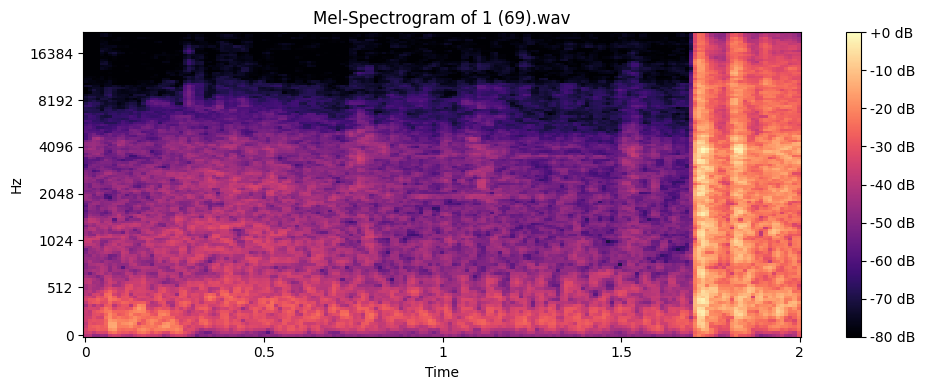

AK-47


In [4]:
import os
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt


data_dir = '/kaggle/input/gunshot-audio-dataset'  


categories = os.listdir(data_dir)


random_category = random.choice(categories)


category_path = os.path.join(data_dir, random_category)
audio_files = os.listdir(category_path)


random_audio_file = random.choice(audio_files)
audio_path = os.path.join(category_path, random_audio_file)


y, sr = librosa.load(audio_path, sr=None)


S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_DB = librosa.power_to_db(S, ref=np.max)


plt.figure(figsize=(10, 4))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-Spectrogram of {random_audio_file}')
plt.tight_layout()
plt.show()
print(random_category)


In [5]:
X, y = load_data(data_dir)

In [ ]:
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [ ]:
X_train = np.array([librosa.util.fix_length(mfcc, size=448, axis=1) for mfcc in X_train])
X_train = np.repeat(X_train, 3, axis=-1)  Repeat to make it 3-channel
X_test = np.array([librosa.util.fix_length(mfcc, size=448, axis=1) for mfcc in X_test])
X_test = np.repeat(X_test, 3, axis=-1) 

In [ ]:

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(448, 448, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)  


In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


In [ ]:
model.save('gunshot_classification_mobilenet.h5')


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
from tensorflow.image import resize

categories = os.listdir(data_dir)


label_encoder = LabelEncoder()
label_encoder.fit(categories)

for i in range(5):
  
    random_category = random.choice(categories)

   
    category_path = os.path.join(data_dir, random_category)
    audio_files = os.listdir(category_path)

   
    random_audio_file = random.choice(audio_files)
    audio_path = os.path.join(category_path, random_audio_file)

    
    y, sr = librosa.load(audio_path, sr=None)

   
    display(Audio(y, rate=sr))

    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)


    mfccs = np.expand_dims(mfccs, axis=-1)
    mfccs = resize(mfccs, [448, 448])
    mfccs = np.concatenate([mfccs] * 3, axis=-1)
    mfccs = np.expand_dims(mfccs, axis=0)

    
    predicted_label = model.predict(mfccs)
    predicted_category = label_encoder.inverse_transform([np.argmax(predicted_label)])

    
    print(f'Actual Category: {random_category}')
    print(f'Predicted Category: {predicted_category[0]}')
